In [1]:
from utils import *
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/features_3_sec.csv')

In [3]:
# Identify Features and Target Label
y = data['label']
X = data.drop(columns = ['label','filename','length'])


In [4]:
# Scaling and Data Spiltting  
X = standardize(X)
X_dev, y_dev, X_test, y_test = split(X, y)


X_dev shape: (7992, 57)
X_test shape: (1998, 57)


### Original Model
Building a model with no parameter tuning and using the raw csv file

In [5]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_dev, y_dev)
predsDevknn = model_knn.predict(X_dev)
predsTestknn = model_knn.predict(X_test)

In [6]:
testknn_score =  accuracy_score(y_test, predsTestknn)
devknn_score = accuracy_score(y_dev, predsDevknn)

In [7]:
print("Classification Score for K Neighbors Classifier on Dev dataset:\n")
print("Dev Score : ", devknn_score)
print(classification_report(y_dev, predsDevknn))
print("--------------------------------------------------------")
print("Classification Score for K Neighbors Classifier on Test dataset:\n")
print("Test Score :", testknn_score)
print(classification_report(y_test, predsTestknn))

Classification Score for K Neighbors Classifier on Dev dataset:

Dev Score :  0.9464464464464465
              precision    recall  f1-score   support

       blues       0.95      0.97      0.96       808
   classical       0.92      0.98      0.95       811
     country       0.91      0.93      0.92       786
       disco       0.90      0.97      0.93       792
      hiphop       0.97      0.93      0.95       797
        jazz       0.94      0.93      0.94       777
       metal       0.99      0.97      0.98       813
         pop       0.98      0.92      0.95       796
      reggae       0.94      0.96      0.95       817
        rock       0.95      0.89      0.92       795

    accuracy                           0.95      7992
   macro avg       0.95      0.95      0.95      7992
weighted avg       0.95      0.95      0.95      7992

--------------------------------------------------------
Classification Score for K Neighbors Classifier on Test dataset:

Test Score : 0.889889

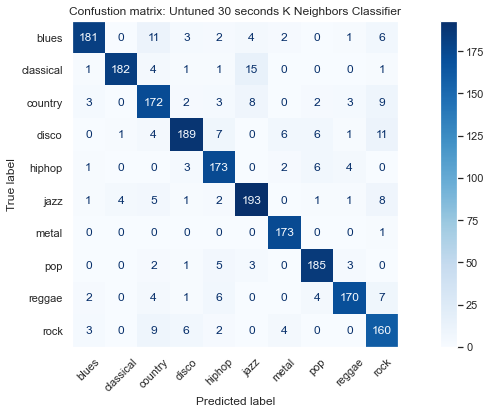

Accuracy : 0.89
Macro F-1 Score : 0.89


In [8]:
# Evaluate Model on Test set
class_labels = list(model_knn.classes_)
macro_f1, accuracy = evaluate_model(predsTestknn, y_test, class_labels, 'Confustion matrix: Untuned 30 seconds K Neighbors Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the raw csv file

In [9]:
criteria = ['gini', 'entropy']
max_depth = [4, 8, 10, 12, 16]

parameters = {'n_neighbors':[5,10,15,20],
            'algorithm':[ 'ball_tree', 'kd_tree', 'brute']}
print(parameters)

{'n_neighbors': [5, 10, 15, 20], 'algorithm': ['ball_tree', 'kd_tree', 'brute']}


In [10]:
tune_knn = GridSearchCV(estimator = model_knn, param_grid = parameters, cv = 5)
tune_knn.fit(X_dev, y_dev)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [5, 10, 15, 20]})

In [11]:
print("Best Score :", tune_knn.best_score_)
print("Best Parameters :",tune_knn.best_params_)

Best Score : 0.8848865960499405
Best Parameters : {'algorithm': 'brute', 'n_neighbors': 5}


In [12]:
predsDevknn_tuned = tune_knn.predict(X_dev)
predsTestknn_tuned = tune_knn.predict(X_test)

print("Score on Dev data for KNN using GridSearchCV:", accuracy_score(y_dev, predsDevknn_tuned))
print("Score on Test data for KNN using GridSearchCV:",accuracy_score(y_test, predsTestknn_tuned))

Score on Dev data for KNN using GridSearchCV: 0.9464464464464465
Score on Test data for KNN using GridSearchCV: 0.8898898898898899


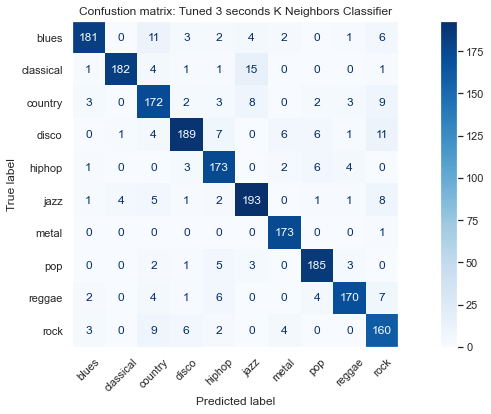

Accuracy : 0.89
Macro F-1 Score : 0.89


In [13]:
# Evaluate Model on Test set
class_labels = list(model_knn.classes_)
macro_f1, accuracy = evaluate_model(predsTestknn_tuned, y_test, class_labels, 'Confustion matrix: Tuned 3 seconds K Neighbors Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Dimensionality reduction of data using PCA

In [14]:
# Principal Component Analysis 
### cite : https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

# create the PCA instance
pca = PCA(n_components=30)
# fit on data
pca_data = pca.fit_transform(X_dev)
pca_data_test = pca.transform(X_test)
# pca_data_dev = pca.transform(X_dev)
PCA_df= pd.DataFrame(data=pca_data)
y_dev.index = PCA_df.index
pca_final=pd.concat([PCA_df,y_dev], axis = 1)
# access values
print("Explained Variance of each component:",pca.explained_variance_)
print("Sum of Explained Variance:", sum(pca.explained_variance_ratio_))

Explained Variance of each component: [0.16211049 0.11190511 0.04944364 0.03409667 0.03089104 0.02431167
 0.0172229  0.01586461 0.01282323 0.01102709 0.00926644 0.00886366
 0.00802953 0.00707014 0.00658936 0.00623253 0.00547409 0.00528015
 0.00521743 0.00492072 0.00474648 0.00425841 0.00402978 0.0035636
 0.00341146 0.00334791 0.00301158 0.0029777  0.00291064 0.00280268]
Sum of Explained Variance: 0.9388799493585877


In [15]:
pca_final.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
0,0.072299,-0.412844,0.023072,-0.417214,0.299825,-0.088896,-0.140617,-0.010043,-0.051656,-0.117344,...,0.024520,0.140193,0.010463,-0.034676,-0.032806,0.011784,-0.038989,0.119435,0.002337,metal
1,0.274582,-0.006478,-0.298496,-0.242298,0.143267,0.006232,-0.135088,0.275193,-0.056235,-0.017876,...,0.029732,0.048216,0.021225,-0.028797,-0.009133,0.006029,-0.046063,0.044245,-0.000538,jazz
2,0.317181,-0.069387,-0.276547,-0.327405,0.098027,0.062285,-0.227110,-0.017663,-0.096373,-0.190254,...,-0.006736,0.091619,0.042858,0.021897,-0.003020,-0.011511,-0.077871,0.110644,-0.077615,country
3,-0.291017,-0.097326,0.154852,-0.012074,0.073026,-0.022696,0.001461,0.070600,0.046642,-0.093233,...,0.031992,0.006732,0.046112,0.055252,0.058160,0.074844,0.046258,-0.120436,0.088161,country
4,-0.879330,0.313246,-0.219645,0.027578,0.029235,-0.272867,0.007772,-0.127961,-0.002713,0.007362,...,0.037922,0.022670,0.024684,-0.002260,-0.089271,-0.035118,-0.028023,-0.021200,0.016573,classical


### PCA - Original Model
Building a model with no parameter tuning and using the PCA data

In [17]:
model_pca = KNeighborsClassifier()
model_pca.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainknn = model_pca.predict(pca_data)
pcaTestknn = model_pca.predict(pca_data_test)

In [18]:
pcatestknn_score =  accuracy_score(y_test, pcaTestknn)
pcaknn_score = accuracy_score(y_dev, pcaTrainknn)

In [19]:
print("Classification Score for K Neighbors Classifier on Train dataset:\n")
print("Train Score : ", pcaknn_score)
print("--------------------------------------------------------")
print("Classification Score for K Neighbors Classifier on Test dataset:\n")
print("Test Score :", pcatestknn_score)

Classification Score for K Neighbors Classifier on Train dataset:

Train Score :  0.9366866866866866
--------------------------------------------------------
Classification Score for K Neighbors Classifier on Test dataset:

Test Score : 0.8773773773773774


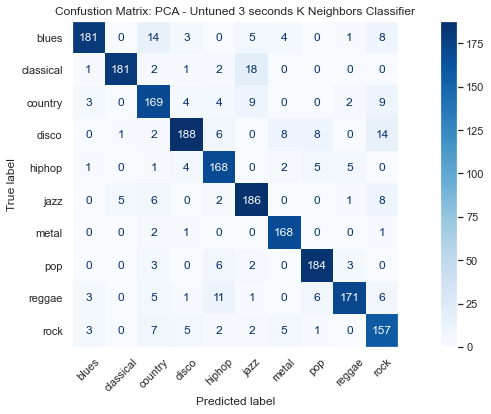

Accuracy : 0.88
Macro F-1 Score : 0.88


In [20]:
# Evaluate Model
class_labels = list(model_knn.classes_)
macro_f1, accuracy = evaluate_model(pcaTestknn, y_test, class_labels, 'Confustion Matrix: PCA - Untuned 3 seconds K Neighbors Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### PCA - Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the PCA data

In [21]:
pca_final.iloc[:,:30]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.072299,-0.412844,0.023072,-0.417214,0.299825,-0.088896,-0.140617,-0.010043,-0.051656,-0.117344,...,-0.052995,0.024520,0.140193,0.010463,-0.034676,-0.032806,0.011784,-0.038989,0.119435,0.002337
1,0.274582,-0.006478,-0.298496,-0.242298,0.143267,0.006232,-0.135088,0.275193,-0.056235,-0.017876,...,-0.011961,0.029732,0.048216,0.021225,-0.028797,-0.009133,0.006029,-0.046063,0.044245,-0.000538
2,0.317181,-0.069387,-0.276547,-0.327405,0.098027,0.062285,-0.227110,-0.017663,-0.096373,-0.190254,...,0.054557,-0.006736,0.091619,0.042858,0.021897,-0.003020,-0.011511,-0.077871,0.110644,-0.077615
3,-0.291017,-0.097326,0.154852,-0.012074,0.073026,-0.022696,0.001461,0.070600,0.046642,-0.093233,...,-0.005706,0.031992,0.006732,0.046112,0.055252,0.058160,0.074844,0.046258,-0.120436,0.088161
4,-0.879330,0.313246,-0.219645,0.027578,0.029235,-0.272867,0.007772,-0.127961,-0.002713,0.007362,...,-0.079279,0.037922,0.022670,0.024684,-0.002260,-0.089271,-0.035118,-0.028023,-0.021200,0.016573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7987,0.377397,-0.033968,-0.295755,-0.057190,0.151605,0.131654,0.035459,0.102107,-0.002049,0.054476,...,-0.063506,0.011610,0.017153,0.045992,0.042077,-0.061335,-0.038839,-0.008658,0.019469,-0.013329
7988,-0.213167,-0.620013,-0.158077,0.127757,0.026842,-0.228275,0.075253,0.001351,0.024657,-0.152187,...,0.003912,-0.025781,0.038528,-0.029224,-0.005239,0.001327,-0.028304,0.017540,0.006314,-0.043838
7989,0.376878,-0.370960,0.473148,-0.024044,-0.082251,0.189682,0.059475,0.106879,0.152482,0.122072,...,-0.003196,0.110537,0.010326,0.142582,0.008615,-0.040282,0.080140,0.033928,0.017480,-0.103955
7990,-0.395842,0.347525,-0.030944,-0.205588,0.025497,-0.198469,-0.050448,-0.159264,-0.205574,0.063804,...,-0.080481,-0.031789,-0.009619,0.021439,-0.060372,0.050377,0.137702,-0.005472,-0.044422,-0.017711


In [22]:
model_pca_tuned = tune_knn
model_pca_tuned.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainknn_tuned = model_pca_tuned.predict(pca_data)
pcaTestknn_tuned = model_pca_tuned.predict(pca_data_test)

In [23]:
pcatestknn_score =  accuracy_score(y_test, pcaTestknn)
pcaknn_score = accuracy_score(y_dev, pcaTrainknn)

In [24]:
print("Classification Score for K Neighbors Classifier on Train dataset:\n")
print("Train Score : ", pcaknn_score)
print("--------------------------------------------------------")
print("Classification Score for K Neighbors Classifier on Test dataset:\n")
print("Test Score :", pcatestknn_score)

Classification Score for K Neighbors Classifier on Train dataset:

Train Score :  0.9366866866866866
--------------------------------------------------------
Classification Score for K Neighbors Classifier on Test dataset:

Test Score : 0.8773773773773774


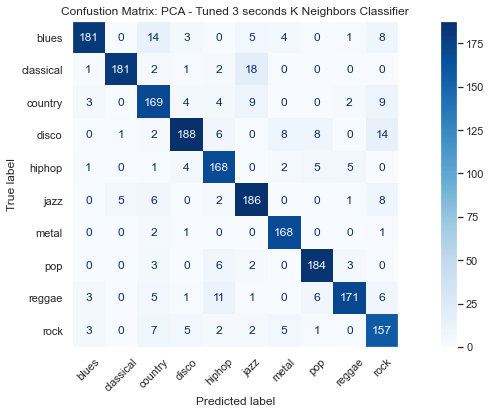

Accuracy : 0.88
Macro F-1 Score : 0.88


In [25]:
# Evaluate Model
class_labels = list(model_knn.classes_)
macro_f1, accuracy = evaluate_model(pcaTestknn, y_test, class_labels, 'Confustion Matrix: PCA - Tuned 3 seconds K Neighbors Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

**Ans:** As we see due to the lesser number of data, PCA instead of helping in the improvement of the accuracy or the model learning by reducing the dimensions ("the curse of dimensionality"), makes the model worse. 